# Load dataset and libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
from collections import defaultdict, Counter

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

In [ ]:
from nltk.corpus import brown

In [ ]:
# Download the Brown corpus
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [ ]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [ ]:
# Print categories in the Brown corpus
categories = brown.categories()
print('Categories: ', categories)

Categories:  ['adventure', 'belles_lettres', 'editorial', 'fiction', 'government', 'hobbies', 'humor', 'learned', 'lore', 'mystery', 'news', 'religion', 'reviews', 'romance', 'science_fiction']


In [ ]:
# Load the Brown corpus with universal tagset
tagged_sentences = brown.tagged_sents(tagset='universal')

# Display the first sentence
print(tagged_sentences[0])

[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')]


# Dataset preparation

In [ ]:
# Extract words and tags
tagged_words = [(word.lower(), tag) for sentence in tagged_sentences for (word, tag) in sentence]
words, tags = zip(*tagged_words)

In [ ]:
unique_tags = set(tags) # Get all the distinct tags present in the dataset
print("No. of unique tags in the Brown corpus: ", len(unique_tags))

No. of unique tags in the Brown corpus:  12


In [ ]:
# Display all the unique tags
unique_tags

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [ ]:
len(words), len(tags) # Get the length of the words to be tagged in the Brown corpus dataset

(1161192, 1161192)

# Calculate transition and emission probabilities

In [ ]:
# Probablity of P(tag_i | tag_i-1)
tag_transition_prob = defaultdict(lambda: defaultdict(float))

# Calculate no. of possibilities for each sequence of 2 tags
for sentence in tagged_sentences:
    prev_tag = "START"
    for word, tag in sentence:
        tag_transition_prob[prev_tag][tag] += 1
        prev_tag = tag
    tag_transition_prob[prev_tag]["END"] += 1

# Calculate probabilities
for prev_tag in tag_transition_prob: # Loop over all tag i
    total_count = sum(tag_transition_prob[prev_tag].values())
    for tag in tag_transition_prob[prev_tag]:
        tag_transition_prob[prev_tag][tag] /= total_count

In [ ]:
# Calculate no. of words for every given tag
word_given_tag_prob = defaultdict(lambda: defaultdict(float))
for word, tag in tagged_words:
    word_given_tag_prob[tag][word] += 1

# Calculate probability from word counts for each tag
for tag in word_given_tag_prob:
    total_count = sum(word_given_tag_prob[tag].values())
    for word in word_given_tag_prob[tag]:
        word_given_tag_prob[tag][word] /= total_count

# Viterbi algorithm code for prediction

In [ ]:
# Function to calculate transition and emission probabilities with Laplace smoothing
# Function is implemented in order to calculate transition and emissionn probabilities given the set of tagged_sentence
# In the above calculation of the same, entire tag set was used
# However, we have to use 5-fold cross validation, which needs this kind of function

def calculate_transition_emission_probabilities(tagged_sentences):
    tag_transition_prob = defaultdict(lambda: defaultdict(float))
    word_given_tag_prob = defaultdict(lambda: defaultdict(float))
    tag_counts = defaultdict(float)

    for sentence in tagged_sentences:
        prev_tag = "START"
        for word, tag in sentence:
            word = word.lower()
            tag_transition_prob[prev_tag][tag] += 1
            word_given_tag_prob[tag][word] += 1
            tag_counts[tag] += 1
            prev_tag = tag
        tag_transition_prob[prev_tag]["END"] += 1

    # Normalize transition probabilities with Laplace smoothing
    for prev_tag in tag_transition_prob:
        total = sum(tag_transition_prob[prev_tag].values()) + len(unique_tags)
        for tag in list(unique_tags) + ["END"]:
            tag_transition_prob[prev_tag][tag] = (tag_transition_prob[prev_tag][tag] + 1) / total

    # Normalize emission probabilities with Laplace smoothing
    for tag in word_given_tag_prob:
        total = tag_counts[tag] + len(word_given_tag_prob[tag])
        for word in word_given_tag_prob[tag]:
            word_given_tag_prob[tag][word] = (word_given_tag_prob[tag][word] + 1) / total

    return tag_transition_prob, word_given_tag_prob

In [ ]:
def viterbi(sentence, transition_probs, emission_probs, unique_tags):

    viterbi_matrix = [{}]
    last_best_tag = [{}]

    # Initialize with the start state using log probabilities
    for tag in unique_tags:
        transition_prob = np.log(transition_probs["START"].get(tag, 1e-6))
        emission_prob = np.log(emission_probs[tag].get(sentence[0].lower(), 1e-6))
        viterbi_matrix[0][tag] = transition_prob + emission_prob
        last_best_tag[0][tag] = "START"

    # Update the viterbi matrix elements for every word in the sentence using log probabilities
    for t in range(1, len(sentence)):
        viterbi_matrix.append({})
        last_best_tag.append({})

        for tag in unique_tags:
            max_prob, best_prev_tag = max(
                (viterbi_matrix[t-1][prev_tag] +
                 np.log(transition_probs[prev_tag].get(tag, 1e-6)) +
                 np.log(emission_probs[tag].get(sentence[t].lower(), 1e-6)), prev_tag)
                for prev_tag in unique_tags
            )
            viterbi_matrix[t][tag] = max_prob
            last_best_tag[t][tag] = best_prev_tag

    # Compute final state probabilities for different paths using log probabilities
    max_prob, best_prev_tag = max(
        (viterbi_matrix[-1][tag] + np.log(transition_probs[tag].get("END", 1e-6)), tag)
        for tag in unique_tags
    )

    # Get the final sequence of tags
    best_path = [best_prev_tag]
    for t in range(len(sentence)-1, 0, -1):
        best_prev_tag = last_best_tag[t][best_prev_tag]
        best_path.insert(0, best_prev_tag)

    return best_path


In [ ]:
# Display POS tagging for one sentence
for tagged_sentence in tagged_sentences:
    sentence = [word.lower() for word, _ in tagged_sentence]
    tags = [tag for _, tag in tagged_sentence]
    predicted_tags = viterbi(sentence, tag_transition_prob, word_given_tag_prob, unique_tags)
    print(sentence)
    print(tags)
    print(predicted_tags)
    break

['the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', "atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']
['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.']
['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'ADJ', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.']


# 5-fold cross validation and HMM training

In [ ]:
# Cross-validation and model evaluation
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
tagged_sentences = np.array(tagged_sentences, dtype=object)
y_true_all, y_pred_all = [], []

for fold, (train_idx, test_idx) in enumerate(kfold.split(tagged_sentences)):
    train_sentences = tagged_sentences[train_idx]
    test_sentences = tagged_sentences[test_idx]

    # Train HMM
    transition_probs, emission_probs = calculate_transition_emission_probabilities(train_sentences)

    y_true, y_pred = [], []

    for sentence in test_sentences:
        words = [word.lower() for word, _ in sentence]
        true_tags = [tag for _, tag in sentence]
        predicted_tags = viterbi(words, transition_probs, emission_probs, unique_tags)

        # Align predictions and true tags (ignore start and end symbols)
        y_true.extend(true_tags)
        y_pred.extend(predicted_tags)

    # Update overall true and predicted lists
    y_true_all.extend(y_true)
    y_pred_all.extend(y_pred)

    # Calculate accuracy for the current fold
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Fold {fold + 1} Accuracy: {accuracy:.4f}')


Fold 1 Accuracy: 0.9585
Fold 2 Accuracy: 0.9587
Fold 3 Accuracy: 0.9579
Fold 4 Accuracy: 0.9592
Fold 5 Accuracy: 0.9579


# Confusion matrix and per POS tag accuracy

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

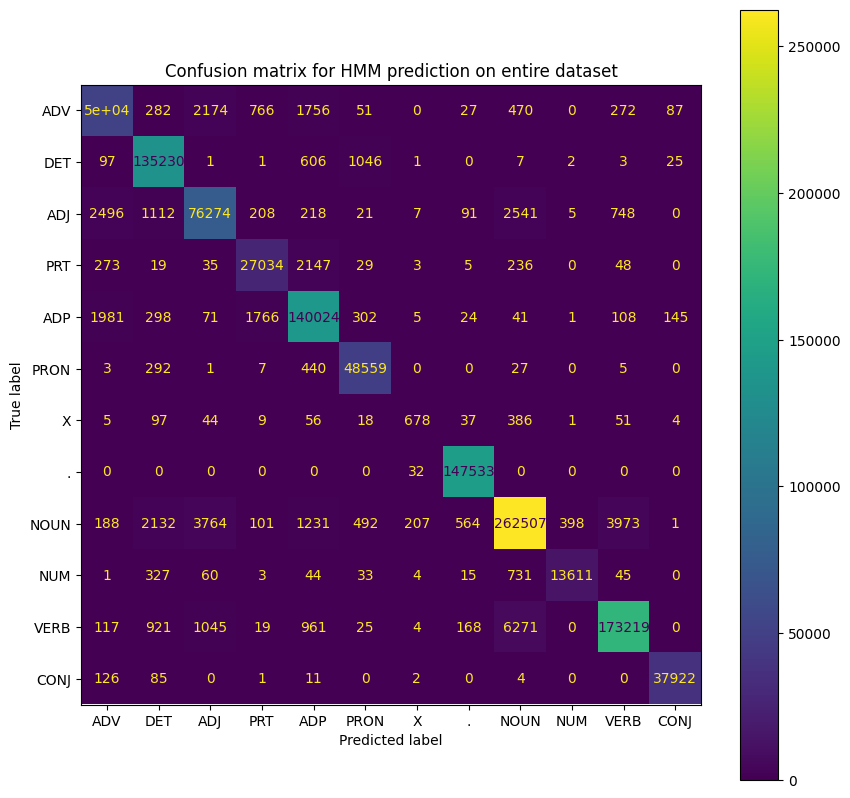

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all, labels=list(unique_tags))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(unique_tags))
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
#disp.plot()
plt.title('Confusion matrix for HMM prediction on entire dataset')
plt.show()

**Per POS tag accuracy**

We report the precision, recall and F-score for the each of the tags.

In [ ]:
# Calculate accuracy for individual POS tags
count = 0
for tag in unique_tags:
  precision = 1.*cm[count,count]/np.sum(cm[:,count])
  recall = 1.*cm[count,count]/np.sum(cm[count,:])
  fscore = 2*precision*recall/(precision+recall)
  print(f'Tag: {tag} ' + f' Precision: {precision:.2f} ' + f' Recall: {recall:.2f} '+ f' F-score: {fscore:.2f} ')
  count += 1

Tag: PRT  Precision: 0.90  Recall: 0.91  F-score: 0.90 
Tag: NOUN  Precision: 0.96  Recall: 0.95  F-score: 0.96 
Tag: DET  Precision: 0.96  Recall: 0.99  F-score: 0.97 
Tag: ADV  Precision: 0.90  Recall: 0.90  F-score: 0.90 
Tag: VERB  Precision: 0.97  Recall: 0.95  F-score: 0.96 
Tag: X  Precision: 0.72  Recall: 0.49  F-score: 0.58 
Tag: PRON  Precision: 0.96  Recall: 0.98  F-score: 0.97 
Tag: ADJ  Precision: 0.91  Recall: 0.91  F-score: 0.91 
Tag: ADP  Precision: 0.95  Recall: 0.97  F-score: 0.96 
Tag: .  Precision: 0.99  Recall: 1.00  F-score: 1.00 
Tag: CONJ  Precision: 0.99  Recall: 0.99  F-score: 0.99 
Tag: NUM  Precision: 0.97  Recall: 0.92  F-score: 0.94 


We obtain the maximum precision, recall, as well as F-score for '.' tag. It seems to be the tag which is correctly identified with ease.

The least precision, recall as well as F-score is recorded for 'X' tag, which has a below 50% recall.

Among the other tags, 'CONJ, 'DET' and 'PRON' are the most accurately predicted tags, possibly because these words rarely have any ambiguity.

The tags where the HMM performance is relatively worse are 'PRT', 'ADJ' and 'ADV'.

# Error analysis of the HMM predictions

In [ ]:
# Display test sentences where more than 1/2 of the words are wrongly tagged
count = 1
for fold, (train_idx, test_idx) in enumerate(kfold.split(tagged_sentences)):
    train_sentences = tagged_sentences[train_idx]
    test_sentences = tagged_sentences[test_idx]

    # Train HMM
    transition_probs, emission_probs = calculate_transition_emission_probabilities(train_sentences)

    for sentence in test_sentences:
        y_true, y_pred = [], []
        words = [word.lower() for word, _ in sentence]
        true_tags = [tag for _, tag in sentence]
        predicted_tags = viterbi(words, transition_probs, emission_probs, unique_tags)

        # Align predictions and true tags (ignore start and end symbols)
        y_true.extend(true_tags)
        y_pred.extend(predicted_tags)

        # Calculate accuracy for the current fold
        sentence = ' '.join([word for word, _ in sentence])
        accuracy = accuracy_score(y_true, y_pred)
        if accuracy < 1/2:
            print(str(count)+'.')
            print(sentence)
            print(y_true)
            print(y_pred)
            count += 1

1.
Boonton
['NOUN']
['.']
2.
Would bar vehicles
['VERB', 'VERB', 'NOUN']
['VERB', 'NOUN', '.']
3.
Board oks pact
['NOUN', 'VERB', 'NOUN']
['NOUN', 'NOUN', '.']
4.
elsewhere
['ADV']
['.']
5.
Instant rivalry
['ADJ', 'NOUN']
['NOUN', '.']
6.
Food : stew a la Mulligatawny
['NOUN', '.', 'NOUN', 'X', 'X', 'NOUN']
['NOUN', '.', 'ADP', 'DET', 'NOUN', '.']
7.
Monument to togetherness
['NOUN', 'ADP', 'NOUN']
['NOUN', 'PRT', '.']
8.
Better ask before joining
['ADJ', 'VERB', 'ADP', 'VERB']
['ADV', 'VERB', 'ADV', '.']
9.
Americana
['NOUN']
['.']
10.
Canned cocktail frankfurters
['VERB', 'NOUN', 'NOUN']
['DET', 'NOUN', '.']
11.
They're easier to shade there .
['PRT', 'ADJ', 'PRT', 'VERB', 'ADV', '.']
['PRT', 'ADV', 'ADP', 'NOUN', 'PRT', '.']
12.
Breathing -- electronically analyzed
['VERB', '.', 'ADV', 'VERB']
['NOUN', '.', 'NOUN', '.']
13.
Dairy
['NOUN']
['.']
14.
Sheep fattening rations
['NOUN', 'VERB', 'NOUN']
['NOUN', 'NOUN', '.']
15.
General
['ADJ']
['NOUN']
16.
Vacations
['NOUN']
['.']
17.
Com

As can be seen from here, most of the incorrect predictions are for single word sentences, which get incorrectly tagged as '.'

Some sentences like 'Siebern hits homer' and 'Breathing -- electronically analyzed' are mistagged because the words 'hits' & 'Breathing' can be both verb and noun and even if given the context, it's hard to probabilistically decide what's its correct tag, even when done by a human subject.

Non english sentences eg: '`` Y que sigue despues ? ' get incorrectly tagged too possibly because of very few instances of these words in the dataset.

# Demo function code

In [ ]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
sentence = input('Enter a sentence: ')

Enter a sentence: I am a nice guy.


In [ ]:
def demo_hmm_pos_tagger(sentence, transition_prob, emission_prob, unique_tags):
  tokens = word_tokenize(sentence)
  tokens_lower_case = [token.lower() for token in tokens]
  predicted_tags = viterbi(tokens_lower_case, transition_prob, emission_prob, unique_tags)
  output = []
  for token, tag in zip(tokens, predicted_tags):
    output.append((token, tag))
  return output

In [ ]:
demo_hmm_pos_tagger(sentence, tag_transition_prob, word_given_tag_prob, unique_tags)

[('I', 'PRON'),
 ('am', 'VERB'),
 ('a', 'DET'),
 ('nice', 'ADJ'),
 ('guy', 'NOUN'),
 ('.', '.')]